In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Labraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

**Importing Dataset**

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Bangladeshi Venomous Snakes Image Dataset/Train"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/Bangladeshi Venomous Snakes Image Dataset/Test"

batch_size = 32
img_size = (128, 128)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

Found 105 files belonging to 3 classes.
Found 45 files belonging to 3 classes.
Class Names: ['Ckrait', 'Kcobra', 'Rviper']


**Processing corrupted images**

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

AUTOTUNE = tf.data.AUTOTUNE

def get_file_paths_and_labels(data_dir):
    all_image_paths = []
    all_labels = []

    class_names_local = sorted([d.name for d in os.scandir(data_dir) if d.is_dir()])
    class_to_label = {name: i for i, name in enumerate(class_names_local)}

    for class_name_local in class_names_local:
        class_path = os.path.join(data_dir, class_name_local)
        file_paths = tf.io.gfile.glob(os.path.join(class_path, '*.[jJpPgG]*'))

        all_image_paths.extend(file_paths)
        all_labels.extend([class_to_label[class_name_local]] * len(file_paths))

    return all_image_paths, all_labels, class_names_local


def is_valid_image(filepath):
    try:
        img_data = tf.io.read_file(filepath.numpy().decode())
        tf.image.decode_image(img_data, channels=3, expand_animations=False)
        return True
    except Exception:
        return False

train_data_dir = train_dir
test_data_dir = test_dir
seed_value = 42

train_all_paths, train_all_labels_int, _ = get_file_paths_and_labels(train_data_dir)
print(f"Total files collected in 'Train' folder before filtering: {len(train_all_paths)}")

print("Starting deep check for corrupted images in Train set...")
train_valid_data = [(path, label) for path, label in zip(train_all_paths, train_all_labels_int)
                    if is_valid_image(tf.constant(path))]
train_all_paths_filtered = [item[0] for item in train_valid_data]
train_all_labels_int_filtered = [item[1] for item in train_valid_data]
print(f"Total valid files remaining in Train after filtering: {len(train_all_paths_filtered)}")
if len(train_all_paths_filtered) == 0:
    raise Exception("No valid images found in Train set after filtering. Check your dataset.")

train_paths, val_paths, train_labels_int, val_labels_int = train_test_split(
    train_all_paths_filtered,
    train_all_labels_int_filtered,
    test_size=0.2,
    random_state=seed_value,
    shuffle=True,
    stratify=train_all_labels_int_filtered
)

test_all_paths, test_all_labels_int, _ = get_file_paths_and_labels(test_data_dir)
print(f"Total files collected in 'Test' folder before filtering: {len(test_all_paths)}")

print("Starting deep check for corrupted images in Test set...")
test_valid_data = [(path, label) for path, label in zip(test_all_paths, test_all_labels_int)
                   if is_valid_image(tf.constant(path))] # Use decode_image in is_valid_image
test_paths_filtered = [item[0] for item in test_valid_data]
test_labels_int_filtered = [item[1] for item in test_valid_data]
print(f"Total valid files remaining in Test after filtering: {len(test_paths_filtered)}")
if len(test_paths_filtered) == 0:
    raise Exception("No valid images found in Test set after filtering. Check your dataset.")


def preprocess_image_and_label(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    label = tf.one_hot(label, num_classes)
    return img, label

global train_ds
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels_int))
train_ds = train_ds.map(preprocess_image_and_label, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(batch_size).cache()


global val_ds
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels_int))
val_ds = val_ds.map(preprocess_image_and_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache()


global test_ds
test_ds = tf.data.Dataset.from_tensor_slices((test_paths_filtered, test_labels_int_filtered))
test_ds = test_ds.map(preprocess_image_and_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(batch_size).cache()

print(f"Number of samples in new train_ds: {len(train_paths)}")
print(f"Number of samples in new val_ds: {len(val_paths)}")
print(f"Number of samples in new test_ds: {len(test_paths_filtered)}")
print("Class Names:", class_names)

Total files collected in 'Train' folder before filtering: 105
Starting deep check for corrupted images in Train set...
Total valid files remaining in Train after filtering: 101
Total files collected in 'Test' folder before filtering: 45
Starting deep check for corrupted images in Test set...
Total valid files remaining in Test after filtering: 45
Number of samples in new train_ds: 80
Number of samples in new val_ds: 21
Number of samples in new test_ds: 45
Class Names: ['Ckrait', 'Kcobra', 'Rviper']


**Visualization**

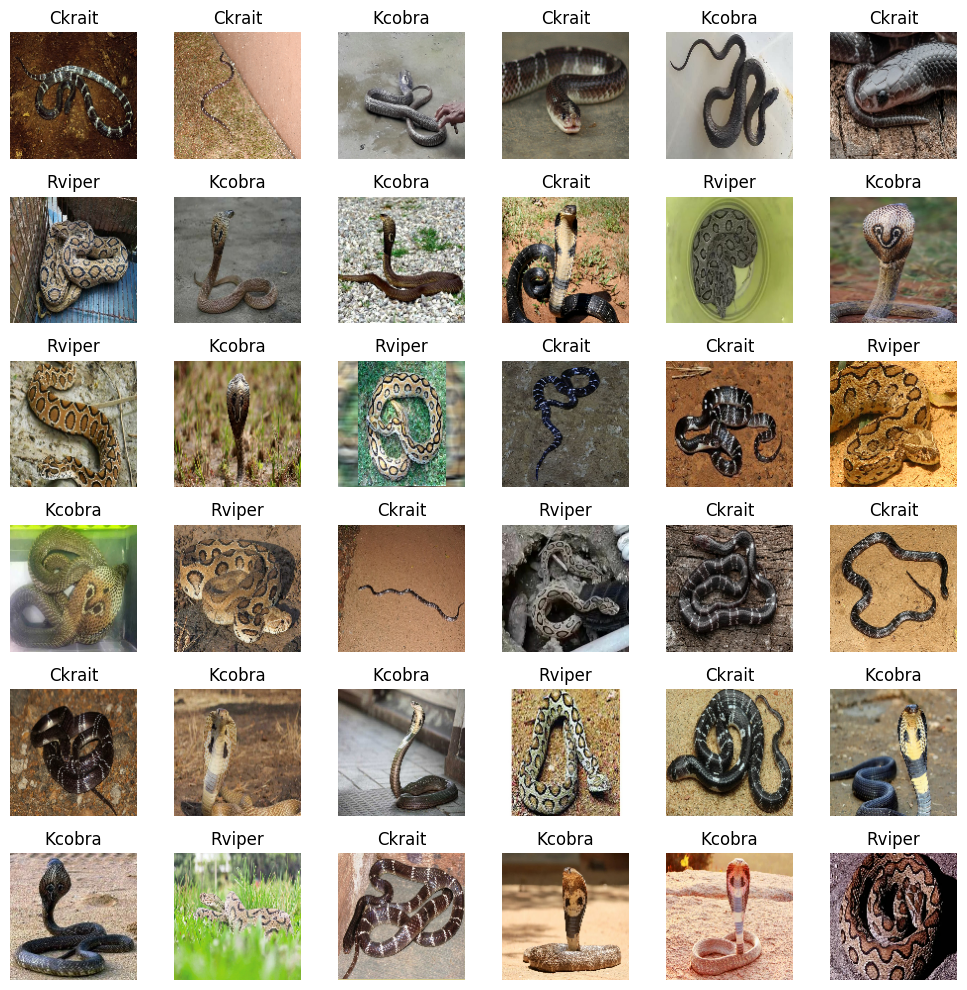

In [ ]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10,10))
for n, (img, label) in enumerate(train_ds.unbatch().shuffle(200).take(36)):
    plt.subplot(6, 6, n + 1)
    plt.imshow(tf.cast(img * 255.0, tf.uint8).numpy())
    plt.axis('off')
    plt.title(class_names[int(tf.argmax(label))])
plt.tight_layout()
plt.show()

**EDA**

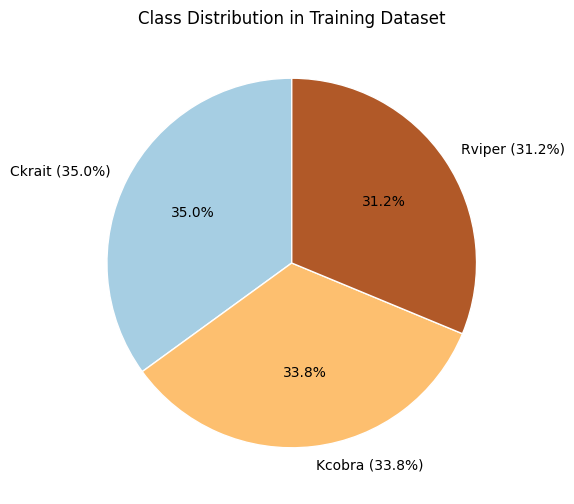

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.zeros(num_classes, dtype=int)

for _, labels in train_ds:
    class_counts += labels.numpy().sum(axis=0).astype(int)

class_percentages = (class_counts / class_counts.sum()) * 100

plt.figure(figsize=(6, 6))
colors = plt.cm.Paired(np.linspace(0, 1, num_classes))
plt.pie(
    class_counts,
    labels=[f"{cls} ({pct:.1f}%)" for cls, pct in zip(class_names, class_percentages)],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Class Distribution in Training Dataset")
plt.show()


**Data Augmentation And Fine Tuning**

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

**Displaying images of each Class after Data Augmentation**

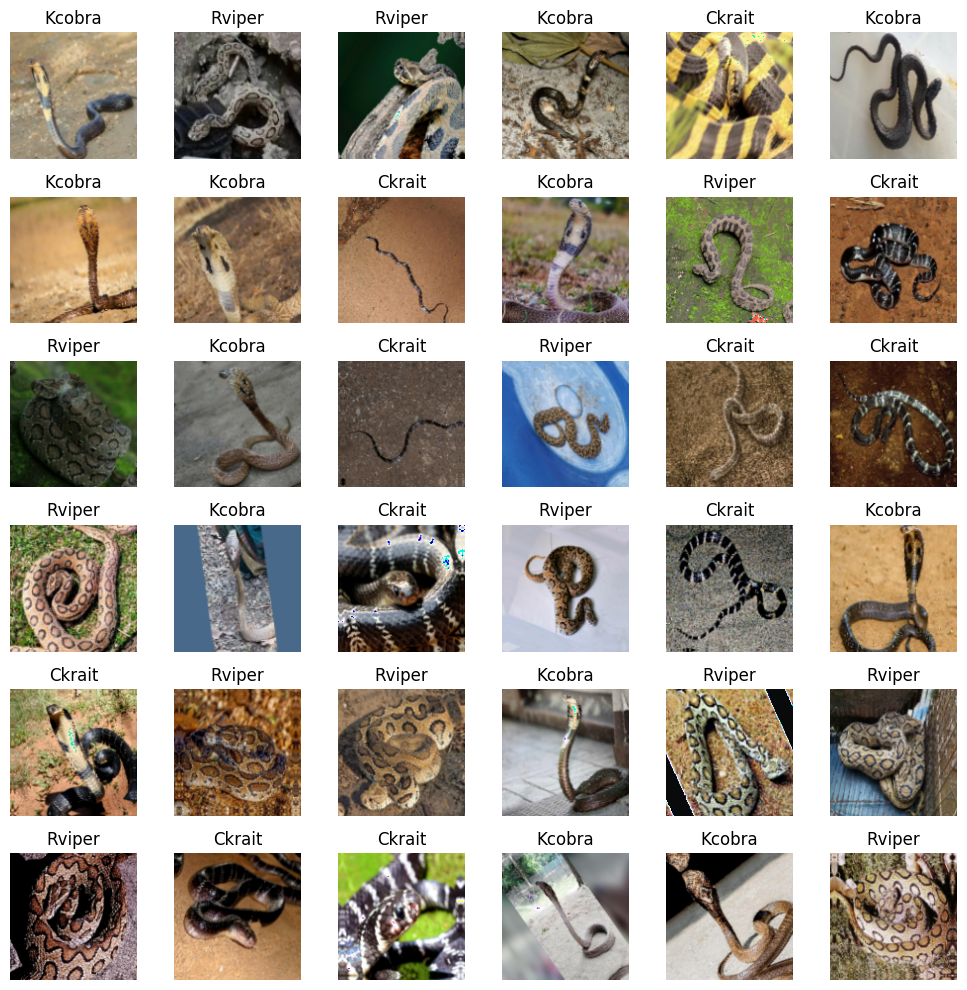

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(10,10))
for n, (img, label) in enumerate(train_ds.unbatch().shuffle(200).take(36)):
    plt.subplot(6, 6, n + 1)
    plt.imshow(tf.cast(img * 255.0, tf.uint8).numpy())
    plt.axis('off')
    plt.title(class_names[int(tf.argmax(label))])
plt.tight_layout()
plt.show()

**Computing class weights to solve imbalanced dataset**

In [ ]:
train_labels = np.concatenate([np.argmax(y, axis=1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9523809523809523), 1: np.float64(0.9876543209876543), 2: np.float64(1.0666666666666667)}


**Function to plot training history**

In [ ]:
def plot_history(history, model_name):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def evaluate_model(model, dataset, model_name):
    y_true = np.concatenate([np.argmax(y, axis=1) for x, y in dataset])
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print(f"=== Classification Report: {model_name} ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

**Custom CNN**

In [ ]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

**Fuction for transfer model**

In [ ]:
def build_transfer_model(base_model, num_classes):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
input_shape = (128,128,3)
epochs = 100
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

results = {}

**CNN**

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.3125 - loss: 11.5389 - val_accuracy: 0.3111 - val_loss: 1.4883
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4992 - loss: 8.1466 - val_accuracy: 0.3333 - val_loss: 1.6524
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5516 - loss: 7.4073 - val_accuracy: 0.3778 - val_loss: 1.4576
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6977 - loss: 4.7579 - val_accuracy: 0.3333 - val_loss: 2.0615
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6898 - loss: 3.4777 - val_accuracy: 0.3556 - val_loss: 2.3057
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7156 - loss: 3.3307 - val_accuracy: 0.3111 - val_loss: 1.6784
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7586 - loss: 1.8603 - val_accuracy: 0.3556 - val_loss: 2.9007
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8430 - loss: 1.9035 - val_accuracy: 0.3556 - val_loss:

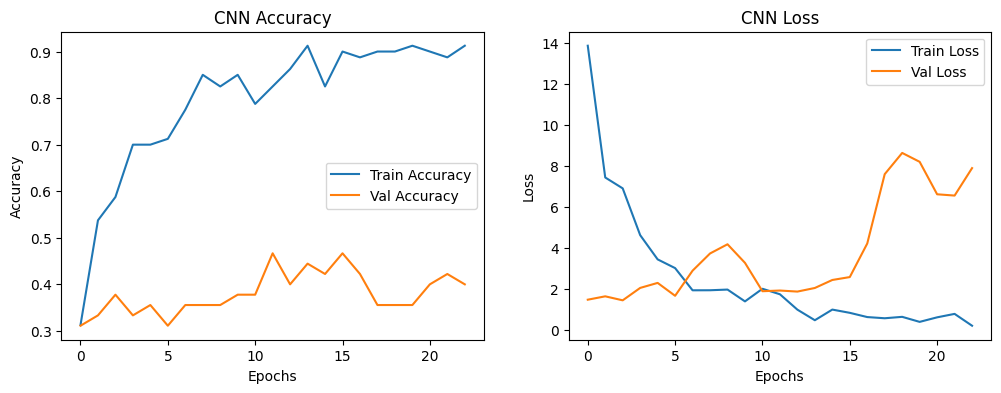

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
=== Classification Report: CNN ===
              precision    recall  f1-score   support

      Ckrait       0.00      0.00      0.00        15
      Kcobra       0.40      0.93      0.56        15
      Rviper       0.30      0.20      0.24        15

    accuracy                           0.38        45
   macro avg       0.23      0.38      0.27        45
weighted avg       0.23      0.38      0.27        45



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


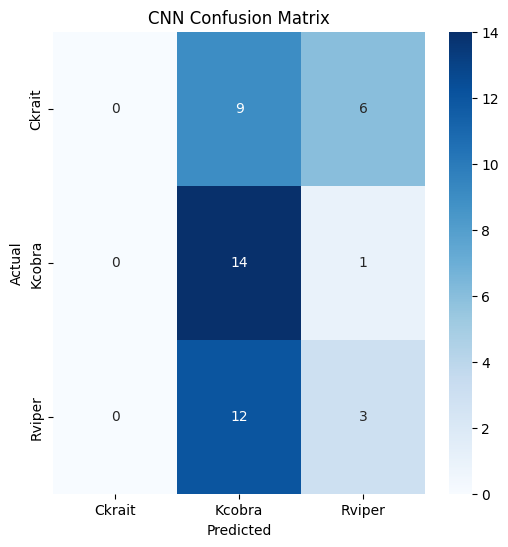

In [ ]:
cnn_model = build_cnn(input_shape, num_classes)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history, "CNN")

evaluate_model(cnn_model, test_ds, "CNN")

results["CNN"] = history.history

**VGG16**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.3711 - loss: 1.3646 - val_accuracy: 0.3333 - val_loss: 1.3380
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.2852 - loss: 1.4596 - val_accuracy: 0.3333 - val_loss: 1.2752
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.3852 - loss: 1.2791 - val_accuracy: 0.3556 - val_loss: 1.2298
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.3562 - loss: 1.2201 - val_accuracy: 0.3556 - val_loss: 1.1985
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.3258 - loss: 1.2199 - val_accuracy: 0.2889 - val_loss: 1.1781
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.3148 - loss: 1.1933 - val_accuracy: 0.2667 - val_loss: 1.1658
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.3805 - loss: 1.1259 - val_accuracy: 0.2222 - val_loss: 1.1580
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy:

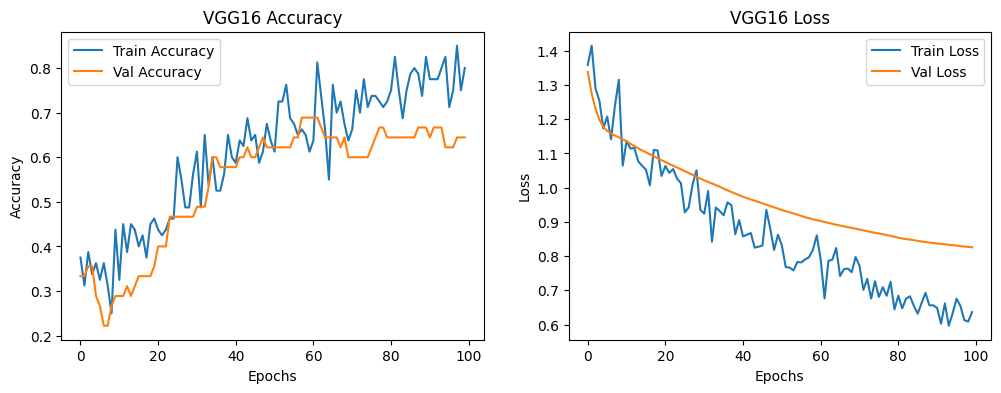

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
=== Classification Report: VGG16 ===
              precision    recall  f1-score   support

      Ckrait       0.73      0.73      0.73        15
      Kcobra       0.69      0.60      0.64        15
      Rviper       0.53      0.60      0.56        15

    accuracy                           0.64        45
   macro avg       0.65      0.64      0.65        45
weighted avg       0.65      0.64      0.65        45



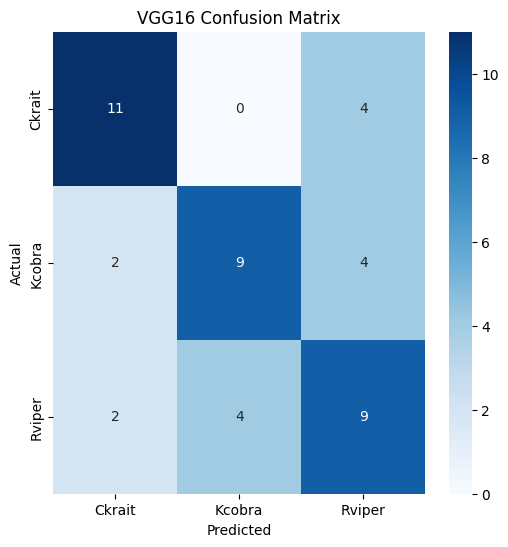

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

new_input_shape = (128, 128, 3)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=new_input_shape)
vgg_base.trainable = False

vgg_model = models.Sequential([
    vgg_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

vgg_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = vgg_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history, "VGG16")

evaluate_model(vgg_model, test_ds, "VGG16")

results["VGG16"] = history.history

**ResNet50**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step - accuracy: 0.3313 - loss: 1.3938 - val_accuracy: 0.3333 - val_loss: 1.1124
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3242 - loss: 1.2867 - val_accuracy: 0.3333 - val_loss: 1.1274
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.3102 - loss: 1.2442 - val_accuracy: 0.3333 - val_loss: 1.0896
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2836 - loss: 1.2221 - val_accuracy: 0.3333 - val_loss: 1.1090
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4102 - loss: 1.1442 - val_accuracy: 0.3333 - val_loss: 1.0959
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4797 - loss: 1.0810 - val_accuracy: 0.3111 - val_loss: 1.0884
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.3383 - loss: 1.1645 - val_accuracy: 0.3111 - val_loss: 1.0871
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0

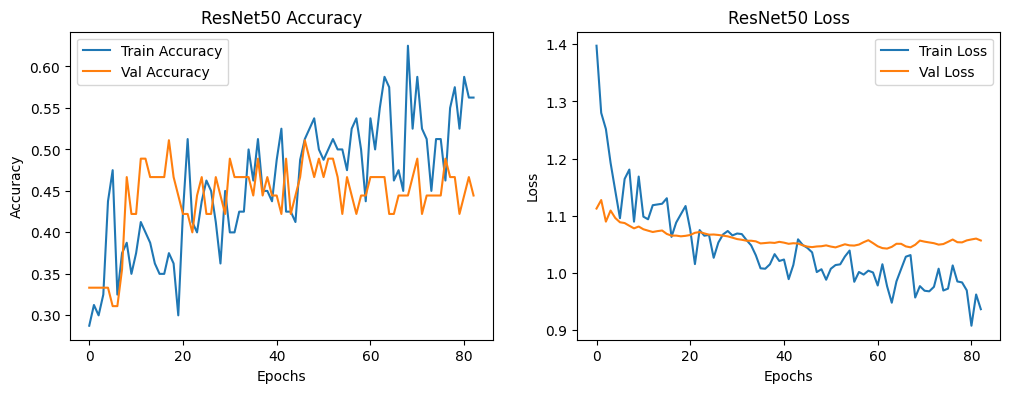

1/2 ━━━━━━━━━━━━━━━━━━━━ 4s 5s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
=== Classification Report: ResNet50 ===
              precision    recall  f1-score   support

      Ckrait       0.38      0.33      0.36        15
      Kcobra       0.56      0.60      0.58        15
      Rviper       0.44      0.47      0.45        15

    accuracy                           0.47        45
   macro avg       0.46      0.47      0.46        45
weighted avg       0.46      0.47      0.46        45



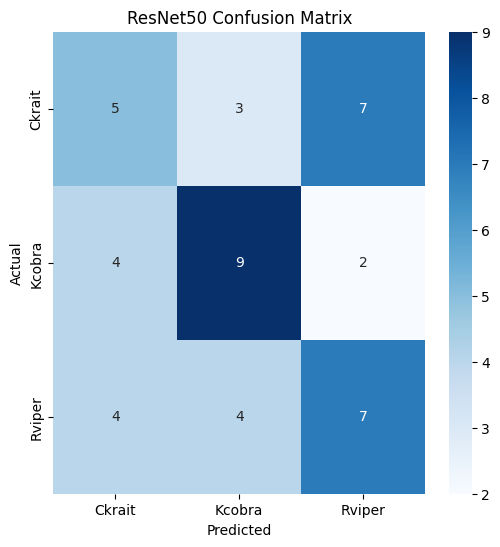

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet_base.trainable = False

resnet_model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

resnet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = resnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history, "ResNet50")

evaluate_model(resnet_model, test_ds, "ResNet50")

results["ResNet50"] = history.history

**MobileNetV2**

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 13s/step - accuracy: 0.4109 - loss: 1.2503 - val_accuracy: 0.7556 - val_loss: 0.6323
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7789 - loss: 0.5269 - val_accuracy: 0.8222 - val_loss: 0.4686
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8367 - loss: 0.4208 - val_accuracy: 0.8889 - val_loss: 0.3510
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9516 - loss: 0.1476 - val_accuracy: 0.8889 - val_loss: 0.3377
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9516 - loss: 0.2355 - val_accuracy: 0.8667 - val_loss: 0.3185
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9258 - loss: 0.2081 - val_accuracy: 0.8889 - val_loss: 0.3197
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9937 - loss: 0.0623 - val_accuracy: 0.9111 - val_loss: 0.3556
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0

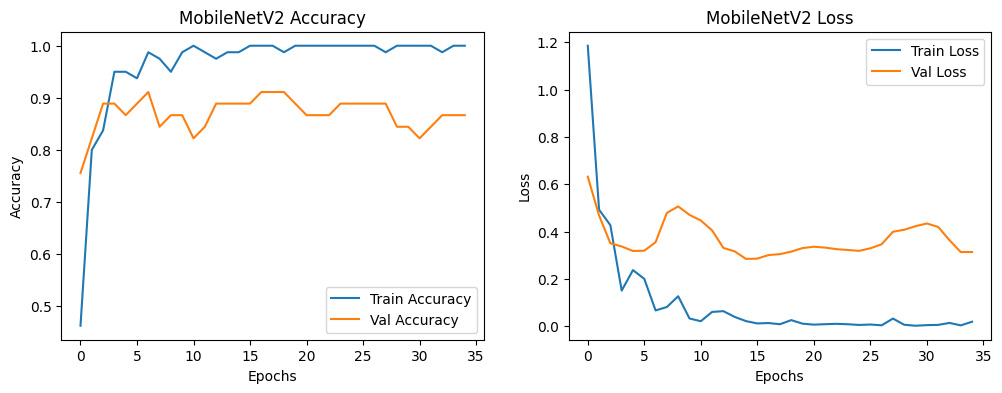

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
=== Classification Report: MobileNetV2 ===
              precision    recall  f1-score   support

      Ckrait       0.79      1.00      0.88        15
      Kcobra       0.93      0.87      0.90        15
      Rviper       1.00      0.80      0.89        15

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.89        45
weighted avg       0.91      0.89      0.89        45



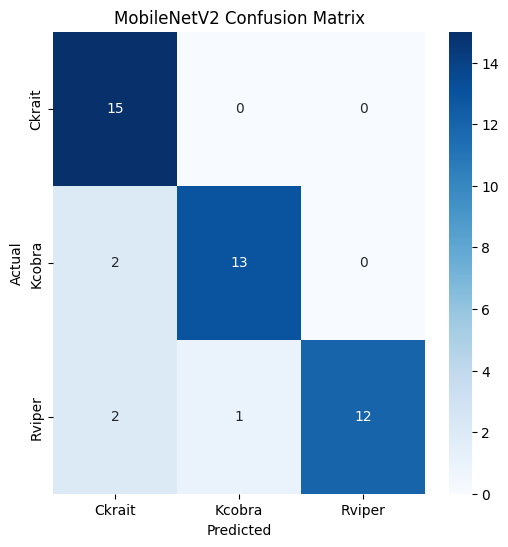

In [ ]:
from tensorflow.keras.applications import MobileNetV2

mobile_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobile_base.trainable = False

mobile_model = models.Sequential([
    mobile_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

mobile_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = mobile_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history, "MobileNetV2")

evaluate_model(mobile_model, test_ds, "MobileNetV2")

results["MobileNetV2"] = history.history

**InceptionV3**

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.2695 - loss: 3.7647 - val_accuracy: 0.4222 - val_loss: 3.1027
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.5836 - loss: 2.2569 - val_accuracy: 0.6444 - val_loss: 1.4727
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6641 - loss: 1.6993 - val_accuracy: 0.6667 - val_loss: 1.3344
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.6695 - loss: 1.5911 - val_accuracy: 0.6000 - val_loss: 1.3843
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.8156 - loss: 0.7329 - val_accuracy: 0.7778 - val_loss: 0.9567
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7945 - loss: 0.8304 - val_accuracy: 0.6889 - val_loss: 1.4566
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7797 - loss: 1.2277 - val_accuracy: 0.6889 - val_loss: 1.1092
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.

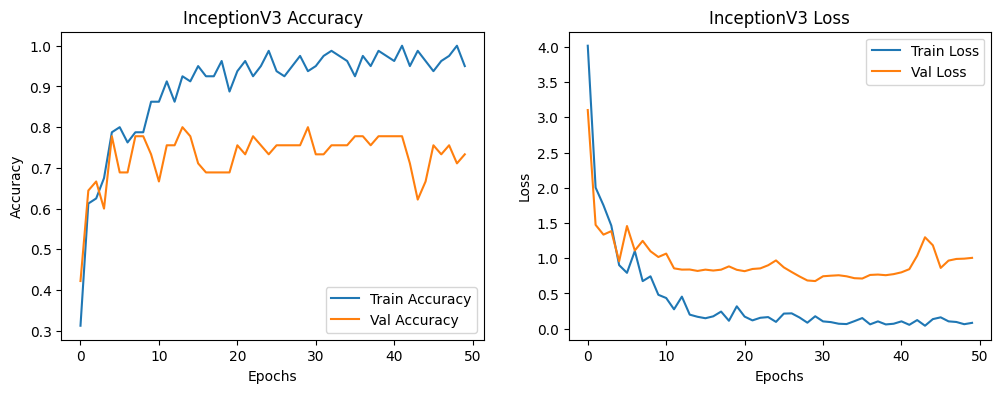

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step
=== Classification Report: InceptionV3 ===
              precision    recall  f1-score   support

      Ckrait       0.88      0.93      0.90        15
      Kcobra       0.80      0.80      0.80        15
      Rviper       0.71      0.67      0.69        15

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.80        45
weighted avg       0.80      0.80      0.80        45



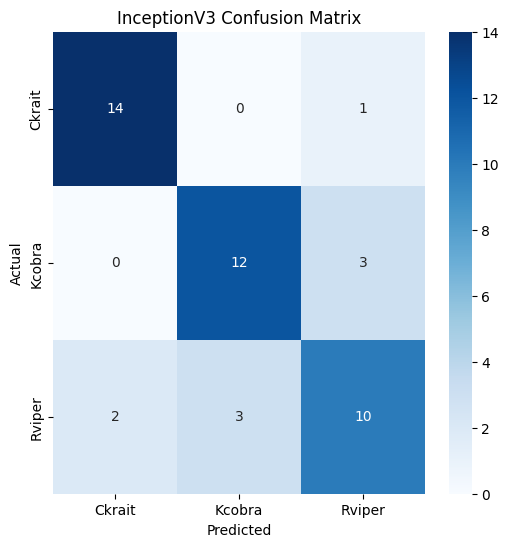

In [ ]:
from tensorflow.keras.applications import InceptionV3

inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
inception_base.trainable = False

inception_model = models.Sequential([
    inception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

inception_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = inception_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

plot_history(history, "InceptionV3")

evaluate_model(inception_model, test_ds, "InceptionV3")

results["InceptionV3"] = history.history

Saving Best model

In [ ]:
mobile_model.save("Venomous_Snake_Detection_mobilenetv2.h5")

CNN prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


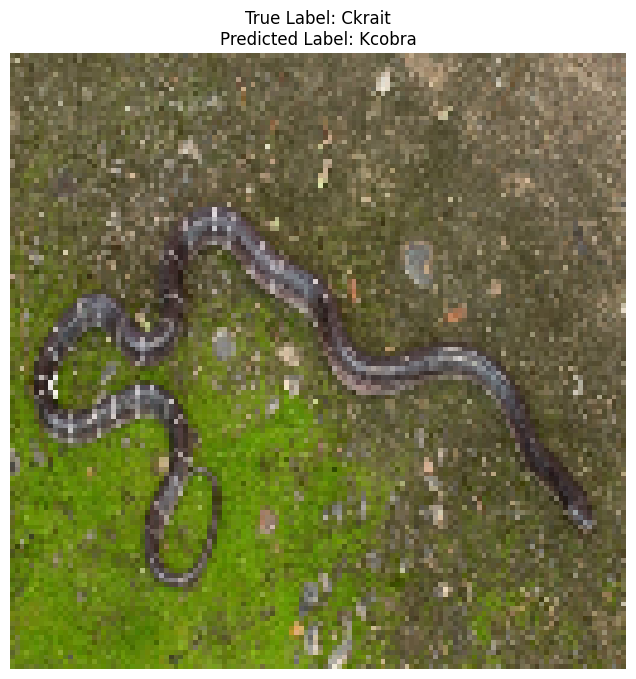

Confidence Scores (Probabilities):
  Ckrait: 0.0560
  Kcobra: 0.6256
  Rviper: 0.3184


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, label_batch in test_ds.take(1):
    sample_image = img_batch[0]
    true_label_one_hot = label_batch[0].numpy()
    break

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = cnn_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image.numpy())
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

VGG16 prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


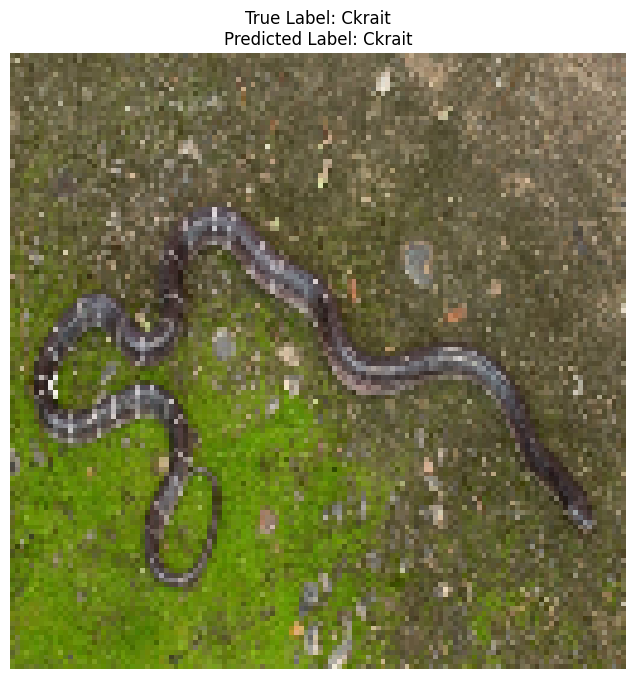

Confidence Scores (Probabilities):
  Ckrait: 0.5740
  Kcobra: 0.2385
  Rviper: 0.1875


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, label_batch in test_ds.take(1):
    sample_image = img_batch[0]
    true_label_one_hot = label_batch[0].numpy()
    break

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = vgg_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image.numpy())
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

ResNet50 prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


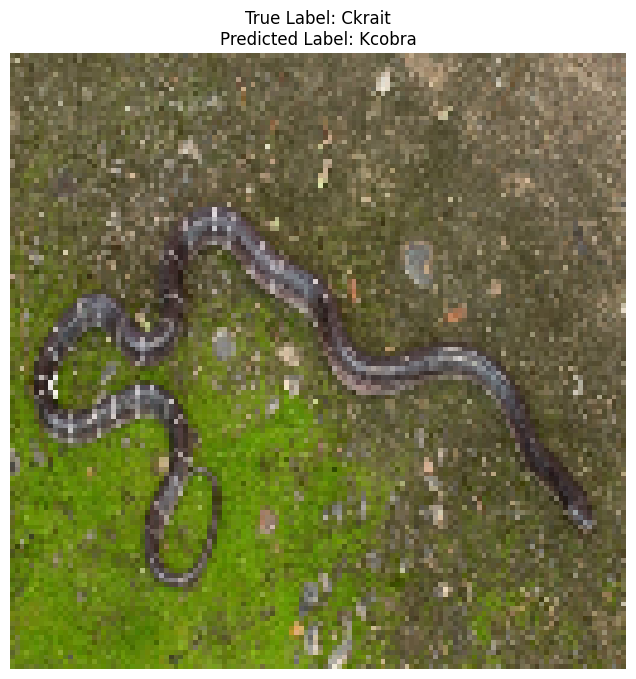

Confidence Scores (Probabilities):
  Ckrait: 0.3605
  Kcobra: 0.4050
  Rviper: 0.2345


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, label_batch in test_ds.take(1):
    sample_image = img_batch[0]
    true_label_one_hot = label_batch[0].numpy()
    break

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = resnet_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image.numpy())
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

MobilenetV2 prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


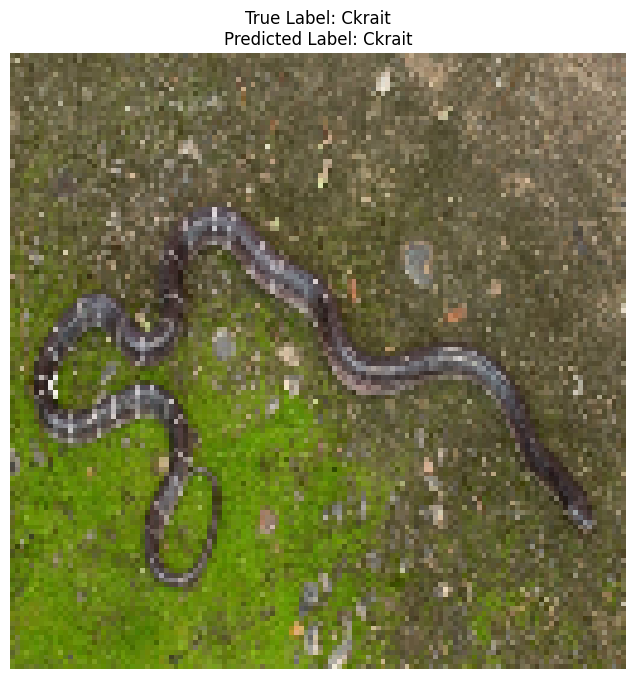

Confidence Scores (Probabilities):
  Ckrait: 0.8722
  Kcobra: 0.0106
  Rviper: 0.1172


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, label_batch in test_ds.take(1):
    sample_image = img_batch[0]
    true_label_one_hot = label_batch[0].numpy()
    break

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = mobile_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image.numpy())
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")

InceptionV3 prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


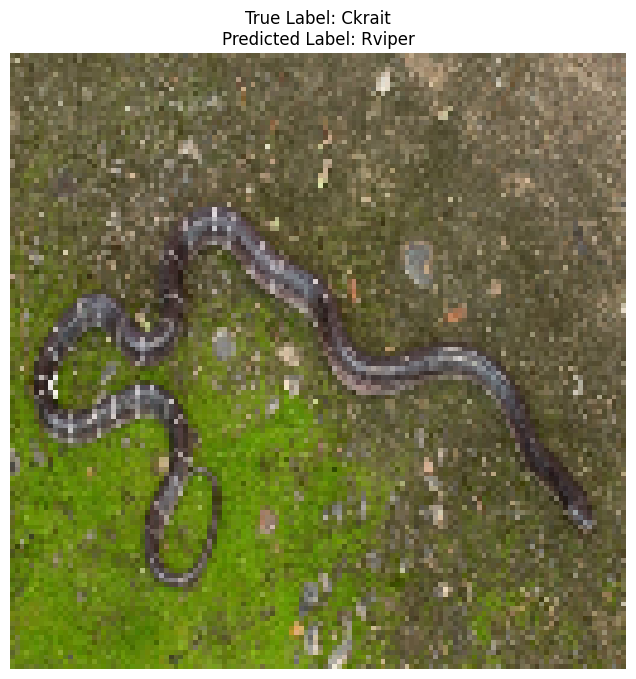

Confidence Scores (Probabilities):
  Ckrait: 0.1051
  Kcobra: 0.0581
  Rviper: 0.8368


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for img_batch, label_batch in test_ds.take(1):
    sample_image = img_batch[0]
    true_label_one_hot = label_batch[0].numpy()
    break

true_label_idx = np.argmax(true_label_one_hot)
true_class_name = class_names[true_label_idx]

input_image_for_prediction = np.expand_dims(sample_image, axis=0)

predictions = inception_model.predict(input_image_for_prediction)
predicted_probabilities = predictions[0]
predicted_label_idx = np.argmax(predicted_probabilities)
predicted_class_name = class_names[predicted_label_idx]

plt.figure(figsize=(8, 8))
plt.imshow(sample_image.numpy())
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print("Confidence Scores (Probabilities):")
for i, prob in enumerate(predicted_probabilities):
    print(f"  {class_names[i]}: {prob:.4f}")